# 한식 분류 모델
test_in&out
- 직접 찍은 사진을 input 으로 주어 모델 output 테스트

/home/team15/ai/yolov3 에서 실행

In [1]:
import argparse

from models import *  # set ONNX_EXPORT in models.py
from utils.datasets import *
from utils.utils import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--cfg', type=str, default='cfg/yolov3-spp-403cls.cfg', help='*.cfg path')
parser.add_argument('--names', type=str, default='data/403food.names', help='*.names path')
parser.add_argument('--weights', type=str, default='weights/best_403food_e200b150v2.pt', help='weights path')
parser.add_argument('--source', type=str, default='data/samples', help='source')  # input file/folder, 0 for webcam
parser.add_argument('--output', type=str, default='output', help='output folder')  # output folder
parser.add_argument('--img-size', type=int, default=512, help='inference size (pixels)')
parser.add_argument('--conf-thres', type=float, default=0.3, help='object confidence threshold')
parser.add_argument('--iou-thres', type=float, default=0.6, help='IOU threshold for NMS')
parser.add_argument('--fourcc', type=str, default='mp4v', help='output video codec (verify ffmpeg support)')
parser.add_argument('--half', action='store_true', help='half precision FP16 inference')
parser.add_argument('--device', default='', help='device id (i.e. 0 or 0,1) or cpu')
parser.add_argument('--view-img', action='store_true', help='display results')
parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
parser.add_argument('--classes', nargs='+', type=int, help='filter by class')
parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
parser.add_argument('--augment', action='store_true', help='augmented inference')


opt, _ = parser.parse_known_args()
opt.cfg = check_file(opt.cfg)  # check file
opt.names = check_file(opt.names)  # check file
print(opt)

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-spp-403cls.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/403food.names', output='output', save_txt=False, source='data/samples', view_img=False, weights='weights/best_403food_e200b150v2.pt')


# 모델 정의

In [3]:
model = Darknet(opt.cfg, (320, 192))

model.cuda()

Model Summary: 225 layers, 6.47596e+07 parameters, 6.47596e+07 gradients


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (Conv2d): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(64, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (Conv2d): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


# 모델 로드
저장된 모델 파라미터에 정의된 모델 파라미터 이외의 정보가 추가로 있어 ('total' 이란 이름이 붙은 파라미터들)

필요 없는 파라미터 제외 후, 모델 가중치 불러오기

In [4]:
state_dict = torch.load(opt.weights)

state_dict = state_dict['model']

new_state_dict = {key:state_dict[key] for key in state_dict.keys() if 'total' not in key}

model.load_state_dict(new_state_dict)

<All keys matched successfully>

### 모델 eval 모드로 전환
학습이 아닌 평가(혹은 추론)을 위한 모드로 전환

In [5]:
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (Conv2d): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(64, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (Conv2d): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


# 추론 예시

In [6]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### 이미지 불러오기
cv2 이용하여 이미지 불러와서 torch 모델에 입력하기 위한 tensor 형태로 변환.

In [22]:
img = cv2.imread('test_6-3.jpeg')
img_org = img[..., ::-1].copy() # BGR 이미지 -> RGB 이미지 원본이미지 저장
img = cv2.resize(img, dsize=(320, 192))
img = torch.from_numpy(img[..., ::-1].copy())
img = img.permute(2, 0, 1)
img = img[None, ...]
img = img / 255.0

print(img.shape)

torch.Size([1, 3, 192, 320])


### 추론

In [23]:
res = model(img.cuda())

pred = non_max_suppression(res[0], conf_thres=0.3, iou_thres=0.5,
                           multi_label=False, classes=opt.classes, agnostic=opt.agnostic_nms)

print(pred)

[tensor([[  4.24100,  51.83376, 319.43958, 144.58702,   0.66359,   0.00000],
        [ 46.96525,  69.90569, 267.62885, 126.14764,   0.36100, 223.00000]], device='cuda:0', grad_fn=<IndexBackward>)]


### 예측 결과 후처리
예측된 결과를 원래 입력 이미지 크기에 맞춰 후처리

In [24]:
det = pred[0]
det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img_org.shape).round()

print(det)

tensor([[0.00000e+00, 1.46000e+03, 3.02400e+03, 2.62800e+03, 6.63586e-01, 0.00000e+00],
        [8.80000e+01, 1.68700e+03, 2.86800e+03, 2.39600e+03, 3.61000e-01, 2.23000e+02]], device='cuda:0', grad_fn=<CopySlices>)


### 좌표 변환
기존의 left top, right bottom (x1, y1, x2, y2) 좌표에서 left top, width, height (x, y, w, h) 좌표로 변환

In [25]:
x1, y1, x2, y2 = det[0, :4]
x, y, w, h = int(x1), int(y1), int(x2-x1), int(y2-y1)

print(x, y, w, h)

0 1460 3024 1168


### 예측 클래스와 확률

In [26]:
confidence = det[0, 4].item()
label = int(det[0, 5])

print(label, confidence)

0 0.6635863184928894


### 시각화

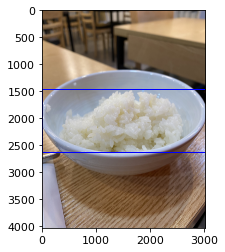

In [27]:
fig, ax = plt.subplots()
ax.imshow(img_org)
ax.add_patch(
    patches.Rectangle(
        (x, y), w, h, edgecolor = 'blue', facecolor='red', fill=False
    )

)

ax.annotate(f"{label}({confidence:.4f})", (x-10, y-10), color='r', fontsize=15)

plt.show()